#Objective: load in EEG data, explore behavioral data, get the power and slow-gamma/theta rates

In [ ]:
"""
1) Load in EEG file
2) Calculate power 
3) Calculate score from behavioral file 
"""

In [2]:
import numpy as np
import mne


In [3]:

path = '/scratch/jsheikh2/ted_temp/ds005505/sub-NDARGJ395FKP/eeg/sub-NDARGJ395FKP_task-seqLearning8target_eeg.set'
#https://mne.tools/stable/generated/mne.io.read_raw_eeglab.html
raw = mne.io.read_raw_eeglab(path)
print(raw)


Reading /scratch/jsheikh2/ted_temp/ds005505/sub-NDARGJ395FKP/eeg/sub-NDARGJ395FKP_task-seqLearning8target_eeg.set
<RawEEGLAB | sub-NDARGJ395FKP_task-seqLearning8target_eeg.set, 129 x 149408 (298.8 s), ~175 KiB, data not loaded>


/tmp/ipykernel_4178937/2585949810.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(path)


In [4]:
#go from raw data to fft https://mne.discourse.group/t/running-fft-on-raw-data/6175
#actually, https://mne.tools/0.21/auto_examples/time_frequency/plot_compute_raw_data_spectrum.html
psd = raw.compute_psd()
print(psd)

Effective window size : 4.096 (s)
<Power Spectrum (from Raw, welch method) | 129 channels × 1025 freqs, 0.0-250.0 Hz>


/tmp/ipykernel_4178937/3392986558.py:3: UserWarning: Zero value in spectrum for channels E67, Cz
  psd = raw.compute_psd()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


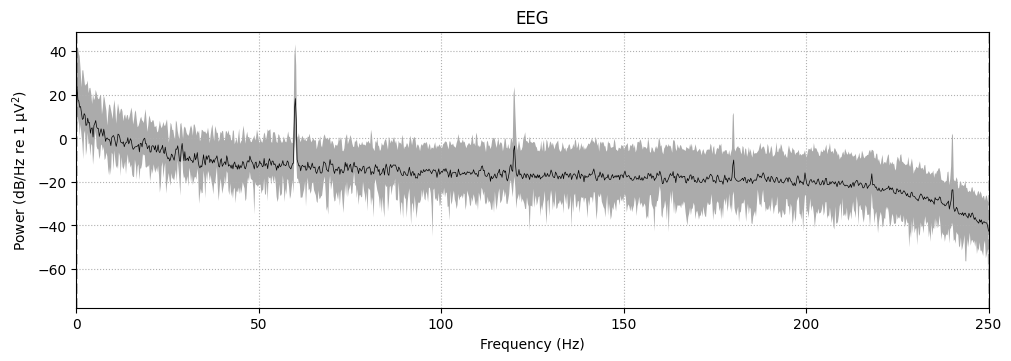

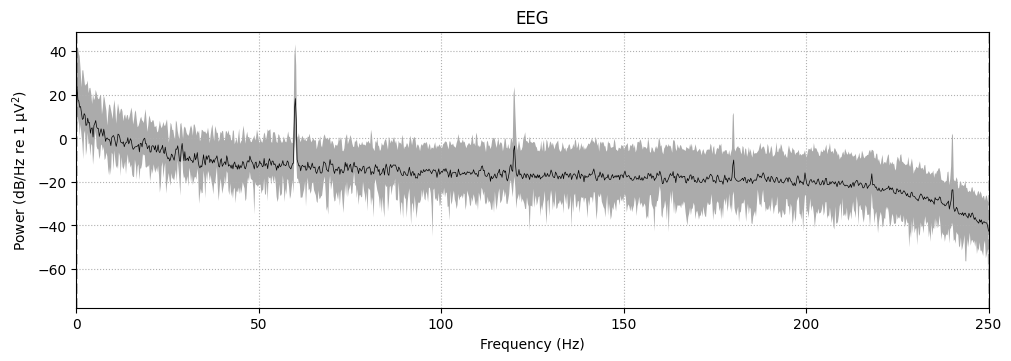

In [5]:
raw.info['bads'] = ['E67', 'Cz']
raw.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

In [6]:
print(psd.freqs)
print(psd.data)

[0.00000000e+00 2.44140625e-01 4.88281250e-01 ... 2.49511719e+02
 2.49755859e+02 2.50000000e+02]
[[6.11960659e-09 5.32180339e-07 2.23828670e-07 ... 1.29405688e-14
  1.91021988e-14 9.09790670e-15]
 [1.53497732e-09 5.19501414e-08 3.35295073e-08 ... 2.97076312e-14
  2.98385433e-14 1.76130925e-14]
 [4.27510211e-11 3.91081328e-10 2.88981649e-10 ... 2.23350981e-15
  2.40105429e-15 1.12352003e-15]
 ...
 [1.19590479e-10 7.46810943e-10 2.85341320e-10 ... 1.45377390e-14
  1.24758590e-14 9.03249753e-15]
 [1.49208903e-10 1.47571401e-09 9.25659007e-10 ... 1.44754274e-14
  1.18731474e-14 8.21496398e-15]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [10]:
# Extract data
freqs = psd.freqs
psd_data = psd.data  # Shape: (n_channels, n_freqs)

# Define frequency bands
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Slow gamma': (20, 55)
}



Band Powers:
Delta: 6.050e-10 μV²/Hz
Theta: 1.643e-11 μV²/Hz
Alpha: 4.216e-12 μV²/Hz
Beta: 2.193e-12 μV²/Hz
Slow gamma: 1.749e-12 μV²/Hz


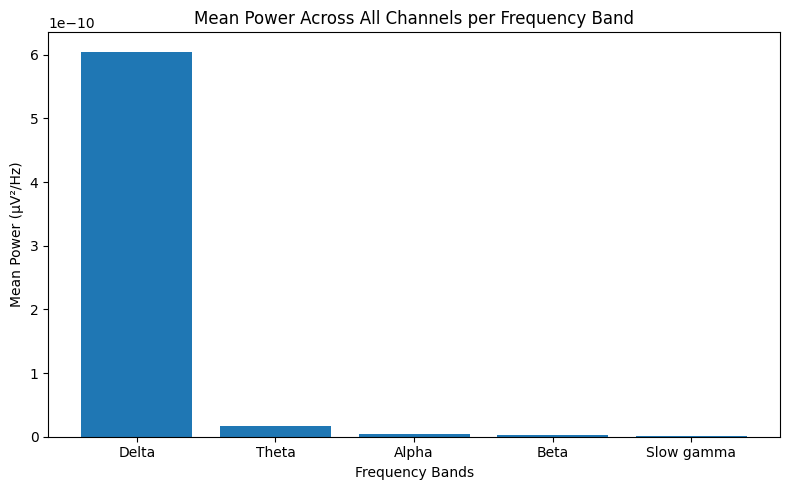

In [11]:
import numpy as np
import matplotlib.pyplot as plt


# Function to calculate mean power for each band
def bandpower(psd, freqs, band):
    """Calculate mean power in a frequency band."""
    # Boolean mask for frequencies in this band
    freq_mask = (freqs >= band[0]) & (freqs <= band[1])
    
    # Mean across frequency bins, then across channels
    # Shape: (n_channels, n_freqs) -> (n_channels,) -> scalar
    band_power = psd[:, freq_mask].mean(axis=-1).mean()
    
    return band_power

# Calculate band power for each band
band_powers = {band: bandpower(psd_data, freqs, bands[band]) 
               for band in bands}

# Print results
print("\nBand Powers:")
for band, power in band_powers.items():
    print(f"{band}: {power:.3e} μV²/Hz")

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bands_names = list(band_powers.keys())
powers = list(band_powers.values())

ax.bar(bands_names, powers)
ax.set_xlabel('Frequency Bands')
ax.set_ylabel('Mean Power (μV²/Hz)')
ax.set_title('Mean Power Across All Channels per Frequency Band')
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()


Event Rate Analysis (Z-score threshold = 2.0)


/tmp/ipykernel_4178937/3464140860.py:36: RuntimeWarning: invalid value encountered in divide
  z_scored = (envelope - envelope.mean(axis=1, keepdims=True)) / envelope.std(axis=1, keepdims=True)



Delta (0.5-4 Hz):
  Event rate: 4.38 events/min (averaged across channels)
  Total events: 2815 (across all channels)
  Mean events per channel: 21.8

Theta (4-8 Hz):
  Event rate: 9.34 events/min (averaged across channels)
  Total events: 6001 (across all channels)
  Mean events per channel: 46.5

Alpha (8-13 Hz):
  Event rate: 12.91 events/min (averaged across channels)
  Total events: 8296 (across all channels)
  Mean events per channel: 64.3

Beta (13-30 Hz):
  Event rate: 23.93 events/min (averaged across channels)
  Total events: 15373 (across all channels)
  Mean events per channel: 119.2

Slow gamma (20-55 Hz):
  Event rate: 39.71 events/min (averaged across channels)
  Total events: 25511 (across all channels)
  Mean events per channel: 197.8


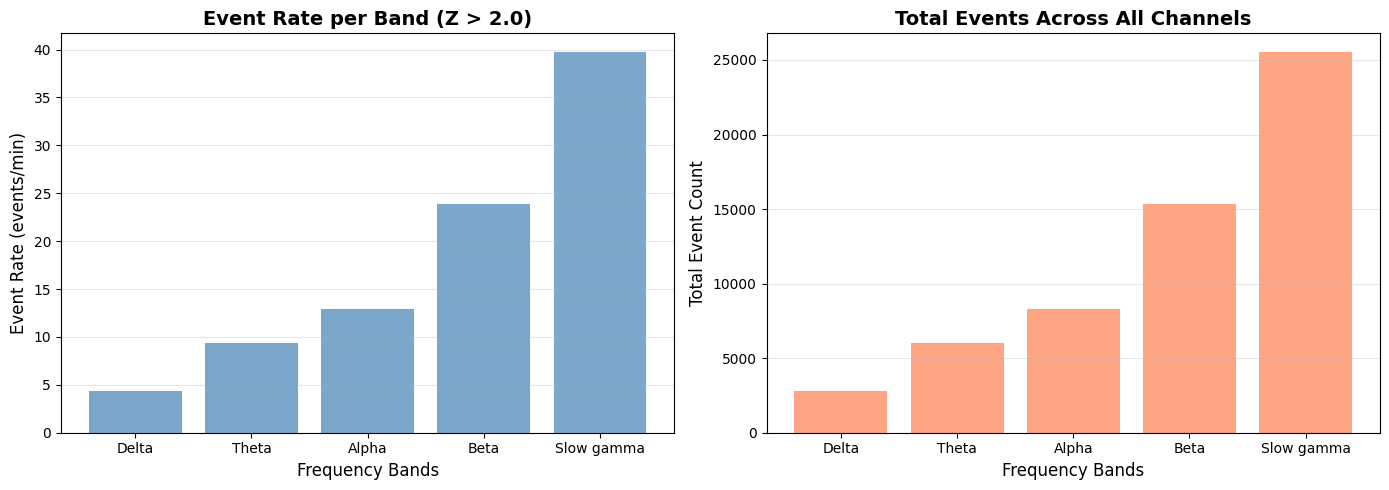

In [12]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Get raw data
raw_data = raw.get_data()  # Shape: (n_channels, n_samples)
sfreq = raw.info['sfreq']  # Sampling frequency
duration_min = raw_data.shape[1] / (sfreq * 60)  # Duration in minutes


def calculate_event_rate_zscore(data, sfreq, band, z_threshold=2.0):
    """
    Calculate event rate as crossings above z-score threshold.
    
    Parameters:
    -----------
    data : array (n_channels, n_samples)
    sfreq : float, sampling frequency
    band : tuple, (low_freq, high_freq)
    z_threshold : float, z-score threshold (default: 2.0)
    
    Returns:
    --------
    event_rate : float, events per minute averaged across channels
    n_events : int, total number of events across all channels
    """
    # Bandpass filter the data
    sos = signal.butter(4, band, btype='bandpass', fs=sfreq, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data, axis=-1)
    
    # Calculate instantaneous power (envelope/amplitude)
    analytic_signal = signal.hilbert(filtered_data, axis=-1)
    envelope = np.abs(analytic_signal)
    
    # Z-score each channel independently
    z_scored = (envelope - envelope.mean(axis=1, keepdims=True)) / envelope.std(axis=1, keepdims=True)
    
    # Detect threshold crossings for each channel
    above_threshold = z_scored > z_threshold
    crossings = np.diff(above_threshold.astype(int), axis=-1)
    n_events_per_channel = np.sum(crossings == 1, axis=-1)  # Count upward crossings
    
    # Total events and average rate
    n_events_total = np.sum(n_events_per_channel)
    n_events_mean = np.mean(n_events_per_channel)
    
    # Calculate rate (events per minute)
    duration_min = data.shape[1] / (sfreq * 60)
    event_rate = n_events_mean / duration_min
    
    return event_rate, n_events_total, n_events_per_channel

# Calculate event rates for each band
event_rates = {}
event_counts = {}

print("\n" + "="*60)
print("Event Rate Analysis (Z-score threshold = 2.0)")
print("="*60)

for band_name, band_range in bands.items():
    rate, total, per_channel = calculate_event_rate_zscore(raw_data, sfreq, band_range)
    event_rates[band_name] = rate
    event_counts[band_name] = total
    print(f"\n{band_name} ({band_range[0]}-{band_range[1]} Hz):")
    print(f"  Event rate: {rate:.2f} events/min (averaged across channels)")
    print(f"  Total events: {total} (across all channels)")
    print(f"  Mean events per channel: {per_channel.mean():.1f}")

# Plot event rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Event rate per minute
ax1.bar(event_rates.keys(), event_rates.values(), color='steelblue', alpha=0.7)
ax1.set_xlabel('Frequency Bands', fontsize=12)
ax1.set_ylabel('Event Rate (events/min)', fontsize=12)
ax1.set_title('Event Rate per Band (Z > 2.0)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Total event counts
ax2.bar(event_counts.keys(), event_counts.values(), color='coral', alpha=0.7)
ax2.set_xlabel('Frequency Bands', fontsize=12)
ax2.set_ylabel('Total Event Count', fontsize=12)
ax2.set_title('Total Events Across All Channels', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()